In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
method_results = {
    'eegnet64': pd.read_csv('results/results_eegnet_64.csv'),
    'eegnet32': pd.read_csv('results/results_eegnet_32.csv'),
    "df_FF_64": pd.read_csv('results/results_eegnetAttention_FF_64.csv'),
    "df_TT_64": pd.read_csv('results/results_eegnetAttention_TT_64.csv'),
    "df_FF_32": pd.read_csv('results/results_eegnetAttention_FF_32.csv'),
    "df_TT_32": pd.read_csv('results/results_eegnetAttention_TT_32.csv'),
}
columns = ['metodo', 'sujeito', 'fold', 'accuracy']


In [3]:
from sklearn.metrics import cohen_kappa_score

methods_data = []
subjects_avg_acc = []
for method_name, df in method_results.items():
    events = ['proba_left_hand', 'proba_right_hand', 'proba_feet', 'proba_tongue']
    proba = np.array(df[events])
    tmin = -2

    predict_proba = []
    labels = np.array(df['label'])
    predict = np.array([np.argmax(proba[i]) for i in range(len(proba))])

    right_proba = np.array([proba[i,labels[i]] for i in range(len(proba))])
    predict_proba = np.array([proba[i,predict[i]] for i in range(len(proba))])

    df['predict'] = predict
    df['right_proba'] = right_proba
    df['predict_proba'] = predict_proba
    df['acerto'] = df['label'] == df['predict']
    df['accuracy'] = sum(df['acerto']) / len(df['acerto'])
    for sub in np.unique(df['subjects']):
        temp_df = df[(df['subjects'] == sub)]
        subjects_avg_acc.append({
            'metodo': method_name,
            'sujeito': sub,
            'avg_accuracy': sum(temp_df['acerto']) / len(temp_df['acerto']),
            'kappa': cohen_kappa_score(temp_df['predict'], temp_df['label'])
        })

        for fold in np.unique(df['fold_number']):
            temp_df = df[(df['subjects'] == sub) & (df['fold_number'] == fold)]
            methods_data.append({
                'metodo': method_name,
                'sujeito': sub,
                'fold': fold,
                'accuracy': sum(temp_df['acerto']) / len(temp_df['acerto']),
                'kappa': cohen_kappa_score( temp_df['predict'], temp_df['label'])
            })
methods_data_df = pd.DataFrame(methods_data)
subjects_avg_acc_df = pd.DataFrame(subjects_avg_acc)

In [4]:
from scipy.stats import kruskal
kruskal(*np.array([methods_data_df[methods_data_df['metodo'] == method]['accuracy'] for method, df in method_results.items()]))

KruskalResult(statistic=1.5759689603307125, pvalue=0.9041400254010926)

C:\Users\davi2\anaconda3\lib\site-packages\scipy\stats\_morestats.py:3255: UserWarning: Exact p-value calculation does not work if there are zeros. Switching to normal approximation.
  warnings.warn("Exact p-value calculation does not work if there are "


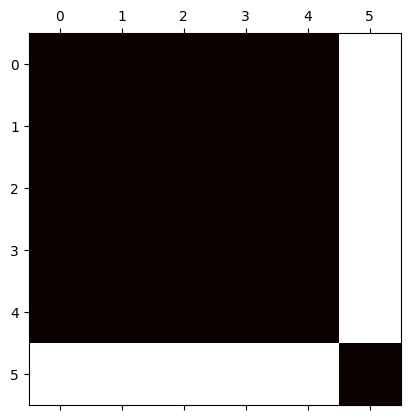

In [5]:
import torch
from scipy.stats import wilcoxon
wilcoxon_matrix = []
for method, df in method_results.items():
    for method2, df2 in method_results.items():
        if method != method2:
            method_acc = np.array(methods_data_df[methods_data_df['metodo'] == method]['kappa'])
            method2_acc = np.array(methods_data_df[methods_data_df['metodo'] == method2]['kappa'])
            res = wilcoxon(method_acc, method2_acc)
            wilcoxon_matrix.append([method, method2, res.pvalue])
        else:
            wilcoxon_matrix.append([method, method2, 1])


wilcoxon_matrix = torch.tensor([result[2] for result in wilcoxon_matrix]).view(len(method_results), len(method_results))
wilcoxon_matrix = wilcoxon_matrix.detach().numpy()
plt.matshow(wilcoxon_matrix<0.05, cmap='hot')

In [6]:
# subjects_avg_acc_df.to_csv('kappa.csv')

In [7]:
np.mean(subjects_avg_acc_df[subjects_avg_acc_df['metodo'] == 'df_TT_32']['avg_accuracy'])

0.7006172839506174

In [8]:
subjects_avg_acc_df[subjects_avg_acc_df['metodo'] == 'df_TT_32']

,metodo,sujeito,avg_accuracy,kappa
45,df_TT_32,1,0.777778,0.703704
46,df_TT_32,2,0.506944,0.342593
47,df_TT_32,3,0.876736,0.835648
48,df_TT_32,4,0.602431,0.469907
49,df_TT_32,5,0.526042,0.368056
50,df_TT_32,6,0.532986,0.377315
51,df_TT_32,7,0.770833,0.694444
52,df_TT_32,8,0.833333,0.777778
53,df_TT_32,9,0.878472,0.837963


In [9]:
import numpy as np
import matplotlib.pyplot as plt


def calc_perprof(df, problem_def, perf_meas, solver_char):
    data = df.sort_values(by=problem_def + solver_char).copy()
    solvers = data[solver_char[0]].unique()
    grouped_by_problem = data.groupby(problem_def)

    for i, (prob, gr) in enumerate(grouped_by_problem):
        data.loc[gr.index, perf_meas] = (gr[perf_meas].max()[0]  / gr[perf_meas])

    grouped_by_solver = data.groupby(solver_char)

    unique_taus = np.sort(data[perf_meas[0]].unique())

    # Finding the fraction of problems that each solver solved within tau
    solver_taus = np.zeros((len(grouped_by_solver), len(unique_taus)))
    print(solver_taus.shape)
    for n, tau in enumerate(unique_taus):
        for i, (_, gr) in enumerate(grouped_by_solver):
            if i == 0 and n == 0:
                print('Number of problems per solver: ', len(gr))
            solver_taus[i, n] = len(gr.loc[gr[perf_meas[0]] <= tau]) / len(grouped_by_problem)

    return unique_taus, solver_taus, solvers, data

def draw_simple_pp(taus, solver_vals, solvers):
    """Simple step plotter for performance profiles.

    Parameters
    ----------
    taus : numpy.ndarray
        x values of plot.
    solver_vals : numpy.ndarray
        y values of plot.
    solvers : list
        Labels of curves.
    """

    fig = plt.figure()
    ax = fig.add_subplot(111)

    # Add lines individually to support labels
    for n, solver in enumerate(solvers):
        ax.step(taus, solver_vals[n, :], where='post', label=solver)

    plt.legend(loc=4)
    plt.xlim(1, taus.max())
    ax.set_xlabel('Tau')
    ax.set_ylabel('Fraction of problems')

    plt.plot()

In [10]:
methods_data_df['sujeito-fold'] = methods_data_df['sujeito'].astype(str) + '-' + methods_data_df['fold'].astype(str)
methods_data_df

,metodo,sujeito,fold,accuracy,kappa,sujeito-fold
0,eegnet64,1,1,0.784483,0.712644,1-1
1,eegnet64,1,2,0.721739,0.629032,1-2
2,eegnet64,1,3,0.756522,0.675174,1-3
3,eegnet64,1,4,0.773913,0.698285,1-4
4,eegnet64,1,5,0.747826,0.663844,1-5
...,...,...,...,...,...,...
265,df_TT_32,9,1,0.905172,0.873563,9-1
266,df_TT_32,9,2,0.843478,0.791310,9-2
267,df_TT_32,9,3,0.860870,0.814535,9-3
268,df_TT_32,9,4,0.930435,0.907202,9-4


In [11]:
methods_data_df.to_csv('results_performance_profiles.csv')

(6, 157)
Number of problems per solver:  45


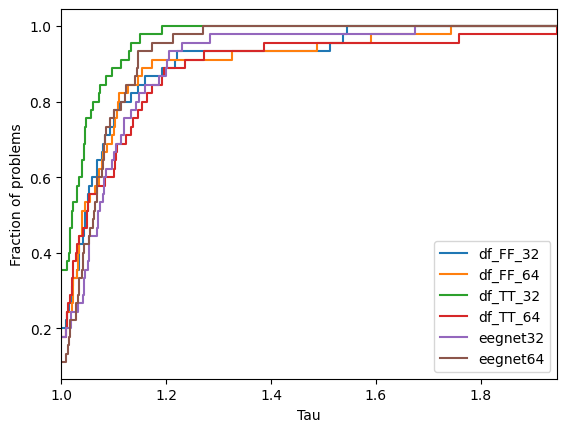

In [12]:
taus, solver_vals, solvers, transformed_data = calc_perprof(methods_data_df, ['sujeito-fold'], ['accuracy'], ['metodo'])

draw_simple_pp(taus, solver_vals, solvers)

(6, 215)
Number of problems per solver:  45


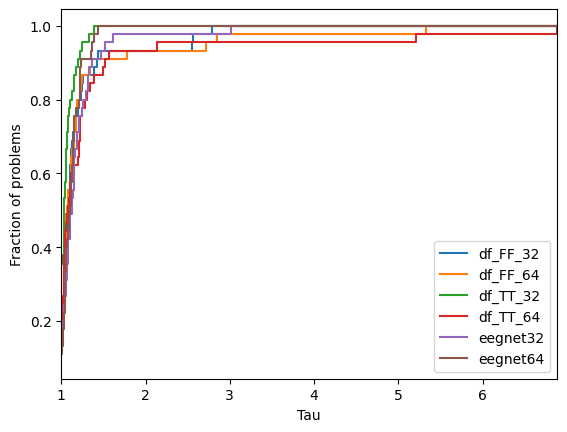

In [13]:
taus, solver_vals, solvers, transformed_data = calc_perprof(methods_data_df, ['sujeito-fold'], ['kappa'], ['metodo'])

draw_simple_pp(taus, solver_vals, solvers)